<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Fri May 28 17:50:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    50W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

Cloning into 'segmentation-of-pelvic-bone'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 310 (delta 182), reused 179 (delta 88), pack-reused 0
Receiving objects: 100% (310/310), 5.67 MiB | 8.03 MiB/s, done.
Resolving deltas: 100% (182/182), done.
     |████████████████████████████████| 47.4MB 106kB/s 
/content/segmentation-of-pelvic-bone/src


In [4]:
!git pull

Already up to date.


In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [4]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [71]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 8.14 s, sys: 513 ms, total: 8.65 s
Wall time: 8.39 s


In [56]:
print(f"X train shape:{data.X_train_3C.shape}, y train shape:{data.y_train.shape} ")
print(f"X val shape:{data.X_val_3C.shape}, y val shape:{data.y_val.shape} ")

X train shape:(815, 300, 150, 3), y train shape:(815,) 
X val shape:(43, 300, 150, 3), y val shape:(43,) 


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.cmn_img[42].min(), data.cmn_img[42].max()))

Min: -1024.000, Max: 3071.000


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_val_3C.min(), data.X_val_3C.max()))

Min: -2.628, Max: 1.531


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_flat_val.min(), data.X_flat_val.max()))

Min: -2.628, Max: 1.531


In [ ]:
X = data.X_flat_train.reshape(data.X_train.shape)
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
X_3c = np.array(
            [np.repeat(x[None, ...], 3, axis=0).T for x in X])
print('Min: %.3f, Max: %.3f' % (X_3c.min(), X_3c.max()))

Min: 0.000, Max: 1.000
Min: 0.000, Max: 1.000


In [72]:
X_train, y_train, X_val, y_val = data.X_train_3C, data.y_train, data.X_val_3C, data.y_val
X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)

## VGG 16

In [118]:
input = tfkl.Input([None, None, 3])
x = tf.cast(input, tf.float32)
# x = tf.image.per_image_standardization(x)
vgg_model = tfk.applications.VGG16(weights="imagenet", include_top=False, pooling="max")
vgg_output = vgg_model(input)
hidden_layer = tfkl.Dense(512, activation='relu')(vgg_output)
hl_reg = tfkl.Dropout(0.7)(hidden_layer)
hidden_layer = tfkl.Dense(256, activation='relu')(hl_reg)
hl_reg = tfkl.Dropout(0.7)(hidden_layer)
hidden_layer = tfkl.Dense(32, activation='relu')(hidden_layer)
hl_reg = tfkl.Dropout(0.5)(hidden_layer)
# hidden_layer = tfkl.Dense(128, activation='relu')(hl_reg)
# hl_reg = tfkl.Dropout(0.5)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [110]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


### Training 

In [119]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics=['acc'])

In [120]:
!rm -r /content/drive/MyDrive/KTH/HL2027/checkpoint/vgg/*
!ls  /content/drive/MyDrive/KTH/HL2027/checkpoint/vgg

In [121]:
checkpoint_filepath = PATH + '/checkpoint/vgg/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/40
26/26 [==============================] - 3s 90ms/step - loss: 0.5287 - acc: 0.8307 - val_loss: 0.3294 - val_acc: 0.8837
Epoch 2/40
26/26 [==============================] - 2s 82ms/step - loss: 0.3957 - acc: 0.8761 - val_loss: 0.2818 - val_acc: 0.8837
Epoch 3/40
26/26 [==============================] - 2s 82ms/step - loss: 0.3524 - acc: 0.8724 - val_loss: 0.1944 - val_acc: 0.8837
Epoch 4/40
26/26 [==============================] - 2s 82ms/step - loss: 0.3009 - acc: 0.8785 - val_loss: 0.1787 - val_acc: 0.9535
Epoch 5/40
26/26 [==============================] - 2s 82ms/step - loss: 0.2507 - acc: 0.8969 - val_loss: 0.1652 - val_acc: 1.0000
Epoch 6/40
26/26 [==============================] - 2s 82ms/step - loss: 0.2092 - acc: 0.9006 - val_loss: 0.0969 - val_acc: 0.9535
Epoch 7/40
26/26 [==============================] - 2s 82ms/step - loss: 0.1682 - acc: 0.9288 - val_loss: 0.0879 - val_acc: 0.9767
Epoch 8/40
26/26 [==============================] - 2s 83ms/step - loss: 0.1348 - a

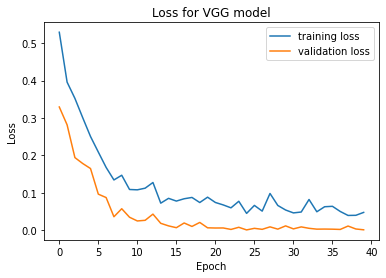

In [122]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

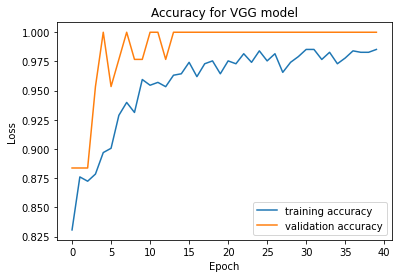

In [123]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Performance on Common Images

In [ ]:
cmn_img.shape

(286, 512, 512, 3)

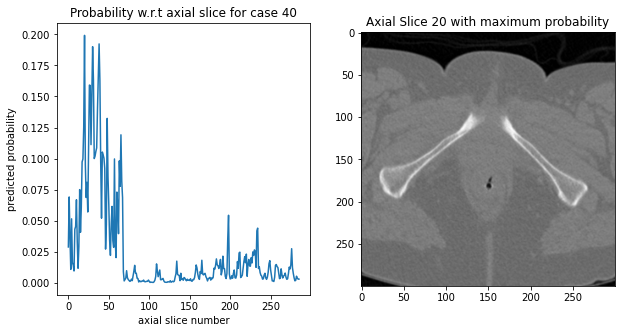

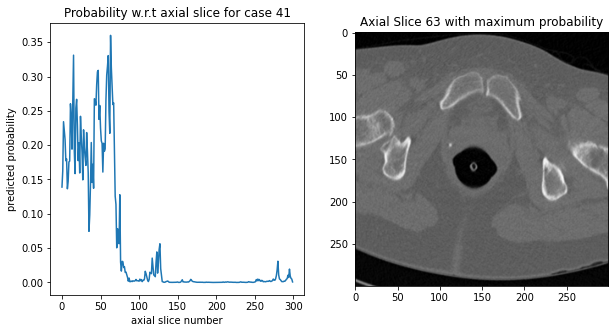

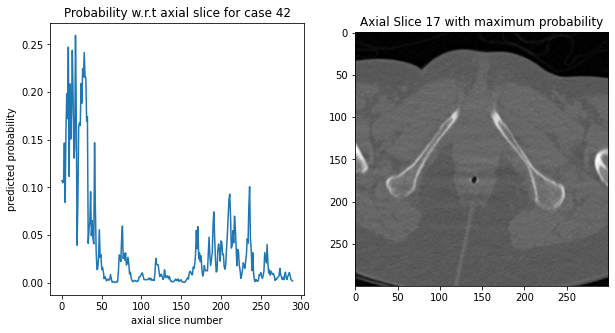

CPU times: user 4.35 s, sys: 220 ms, total: 4.57 s
Wall time: 4.23 s


In [124]:
%%time
for id, cmn_img in data.cmn_img_3c.items():
  # X_flat = np.array([x.flatten() for x in cmn_img])
  # X_flat = data.scaler.transform(X_flat)
  # X = X_flat.reshape(cmn_img.shape)
  # X = np.array(
  #           [np.repeat(x[None, ...], 3, axis=0).T for x in X])
  X_test = tf.image.per_image_standardization(cmn_img)
  y_pred = model.predict(X_test)
  argmax = np.argmax(y_pred)
  plt.figure(figsize=(10,5))

  plt.subplot(121)
  plt.plot(y_pred)
  plt.xlabel("axial slice number")
  plt.ylabel("predicted probability")
  plt.title(f"Probability w.r.t axial slice for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.title(f"Axial Slice {argmax} with maximum probability")
  plt.savefig(f'{PATH}/images/{id}.png')
  plt.show()

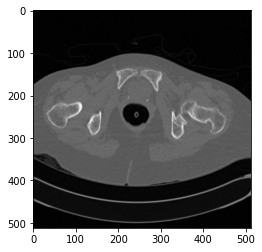

In [ ]:
plt.imshow(data.cmn_img[42][48], cmap="gray")

In [33]:
print(data.cmn_img[40].min(), data.cmn_img[40].max())
print(data.cmn_img[41].min(), data.cmn_img[41].max())
print(data.cmn_img[42].min(), data.cmn_img[42].max())

-1024 3071
-1024 3071
-1024 3071


In [ ]:
model.predict(data.cmn_img_3c[42][48].reshape(1,512,512,3))

array([[0.]], dtype=float32)

## SVM

In [47]:
X_train, y_train, X_val, y_val = data.X_flat_train, data.y_train, data.X_flat_val, data.y_val

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=100, gamma = 0.01, probability=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)

In [52]:
scores

array([0.88343558, 0.88343558, 0.88343558, 0.87730061, 0.87730061])

In [53]:
clf.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

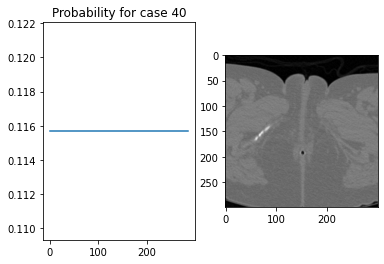

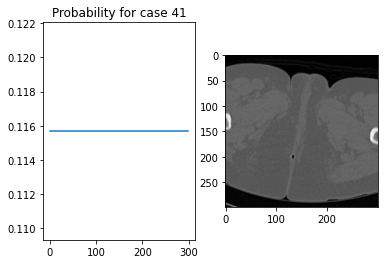

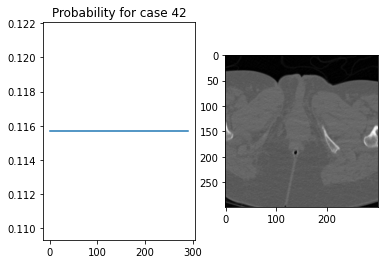

In [54]:
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  y_pred = clf.predict_proba(X_flat)[:,1]
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()